In [143]:
import math
from glob import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from category_encoders import OneHotEncoder
from joblib import dump, load
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
# from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (ElasticNetCV, LassoCV, LinearRegression,
                                  RidgeCV)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor


In [144]:
sns.set_theme(style="whitegrid", font="Verdana")

In [145]:
%matplotlib inline


# Functions

In [146]:
def show_linear_metrics(y_true: np.array, y_pred: np.array) -> None:
    """Prints linear metrics.

    Parameters
    ----------
    y_true : np.array
        y true
    y_pred : np.array
        y predicted
    """
    print("Mean Absolute Error:", mean_absolute_error(y_true=y_true, y_pred=y_pred))
    print("Mean Squared Error:", mean_squared_error(y_true=y_true, y_pred=y_pred))
    print(
        "Root Mean Squared Error:",
        mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
    )
    print("R^2 Score:", r2_score(y_true=y_true, y_pred=y_pred))


# [Dataset](https://drive.google.com/drive/folders/1nfrYxDm7TLzls9pedZbLX5rP4McVDWDe)

In [175]:
DATASET_PATH = "SSD2022AS2"


In [176]:
csv_files = glob(pathname=path.join(DATASET_PATH, "*.csv"), recursive=True)


In [177]:
dfs = list()

for csv_file in csv_files:
    dfs.append(pd.read_csv(filepath_or_buffer=csv_file))

df = pd.concat(objs=dfs, ignore_index=True)


In [178]:
df.timestamp = pd.to_datetime(arg=df.timestamp)


# Session Time

## Pipeline

In [212]:
df_ = df.copy()


In [213]:
df_ = df_.groupby(by=["client_user_id"]).aggregate(
    num_sessions=pd.NamedAgg(column="session_id", aggfunc=np.count_nonzero),
    avg_dropped_frames=pd.NamedAgg(column="dropped_frames", aggfunc=np.mean),
    avg_fps=pd.NamedAgg(column="FPS", aggfunc=np.mean),
    std_fps=pd.NamedAgg(column="FPS", aggfunc=np.std),
    avg_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.mean),
    std_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.std),
    avg_rtt=pd.NamedAgg(column="RTT", aggfunc=np.mean),
    std_rtt=pd.NamedAgg(column="RTT", aggfunc=np.std),
    devices=pd.NamedAgg(column="device", aggfunc=lambda x: ", ".join(x.unique())),
    windows_entry=pd.NamedAgg(
        column="device", aggfunc=lambda x: np.sum(x == "Windows")
    ),
    mac_entry=pd.NamedAgg(column="device", aggfunc=lambda x: np.sum(x == "Mac")),
    android_entry=pd.NamedAgg(
        column="device", aggfunc=lambda x: np.sum(x == "Android")
    ),
    total_hours=pd.NamedAgg(
        column="timestamp", aggfunc=lambda x: np.ptp(x).total_seconds() / 3600
    ),
    last_session=pd.NamedAgg(column="timestamp", aggfunc=np.max),
    first_session=pd.NamedAgg(column="timestamp", aggfunc=np.min),
)

df_["stream_quality"] = 0.0
df_["next_session"] = 0.0

df_ = df_.reset_index()


In [214]:
df_ = df_.replace(to_replace=np.nan, value=0)


In [215]:
df_.to_csv(path_or_buf="output_session_time.csv")


In [216]:
df_


,client_user_id,num_sessions,avg_dropped_frames,avg_fps,std_fps,avg_bitrate,std_bitrate,avg_rtt,std_rtt,devices,windows_entry,mac_entry,android_entry,total_hours,last_session,first_session,stream_quality,next_session
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,228,9.166667,44.337719,18.079243,3883.149123,5381.456809,171.109649,277.138638,Windows,228,0,0,0.315278,2022-09-11 23:18:05,2022-09-11 22:59:10,0.0,0.0
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,870,0.510345,41.864368,12.710460,6415.157471,4366.984310,27.934483,11.900105,Windows,870,0,0,1.209722,2022-09-13 18:13:50,2022-09-13 17:01:15,0.0,0.0
2,006e829c-f656-4836-bc04-bafec3901fdc,2585,1.278143,33.093230,7.385675,11537.770986,7436.004830,52.434429,37.828781,"Windows, Mac",269,2316,0,346.313889,2022-09-20 22:50:05,2022-09-06 12:31:15,0.0,0.0
3,0085ad73-5bcb-4689-ba07-b6ce00b36a8d,1367,0.000000,28.529627,1.693271,8393.614484,3201.918989,37.773226,6.698577,Windows,1367,0,0,29.362500,2022-09-13 16:37:10,2022-09-12 11:15:25,0.0,0.0
4,00eb1b0e-c4bf-4d40-8bc3-3fd59ea7eeb4,738,0.439024,27.246612,3.442711,1181.856369,1825.849440,105.256098,14.272146,Windows,738,0,0,1.023611,2022-09-12 01:25:00,2022-09-12 00:23:35,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,ff34609f-3b66-4250-8fbb-7cd6688ba4ce,1135,0.261674,26.514537,10.417032,2975.335683,3811.275625,171.508370,87.801683,Windows,1135,0,0,10.047222,2022-09-08 00:45:35,2022-09-07 14:42:45,0.0,0.0
1137,ff5c29dc-94cf-4e36-8550-d9a2583ca439,2705,0.812200,25.133826,3.634644,1511.544177,1554.501399,274.875416,234.642044,Windows,2705,0,0,120.123611,2022-09-29 05:54:05,2022-09-24 05:46:40,0.0,0.0
1138,ff6840c7-06cc-4b09-89d9-fb680aed5385,209,0.516746,31.019139,9.701785,977.622010,1123.739711,34.875598,18.736632,Windows,209,0,0,0.295833,2022-09-23 11:33:10,2022-09-23 11:15:25,0.0,0.0
1139,ff88bb69-10c4-41d5-83a7-96663f165c33,225,0.000000,29.213333,1.671398,1715.133333,1404.886018,76.031111,89.208243,Windows,225,0,0,0.311111,2022-09-28 16:42:05,2022-09-28 16:23:25,0.0,0.0


## Data Engineering

In [218]:
df_ = df_.drop(
    labels=[
        "client_user_id",
        "devices",
        "android_entry",
        "last_session",
        "first_session",
    ],
    axis=1,
)


In [160]:
# df_ = OneHotEncoder(cols=["device_unique"], use_cat_names=True).fit_transform(X=df_)


## Split

In [220]:
X = df_.drop(labels=["stream_quality", "next_session"], axis=1)
y = df_.next_session


In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


## Model

In [222]:
cat_boost_regressor = CatBoostRegressor()
cat_boost_regressor.fit(X=X_train, y=y_train)

y_pred = cat_boost_regressor.predict(data=X_test)


CatBoostError: catboost/libs/metrics/metric.cpp:6431: All train targets are equal

In [164]:
dump(cat_boost_regressor, "cat_boost_regressor_session_time.joblib")
# cat_boost_regressor = load("cat_boost_regressor_session_time.joblib")


['cat_boost_regressor_session_time.joblib']

In [165]:
# xgb_regressor = XGBRegressor()
# xgb_regressor.fit(X=X_train, y=y_train)

# y_pred = xgb_regressor.predict(X=X_test)


In [166]:
show_linear_metrics(y_true=y_test, y_pred=y_pred)


Mean Absolute Error: 0.8480169855989607
Mean Squared Error: 2.2691061458175605
Root Mean Squared Error: 1.5063552521956964
R^2 Score: 0.2965560771311859


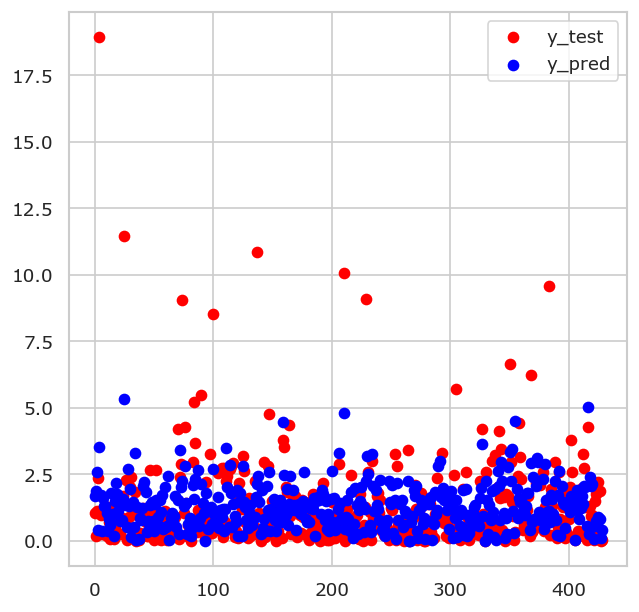

In [167]:
figure = plt.figure(figsize=(6, 6), dpi=120)
subplot = figure.add_subplot()

subplot.scatter(x=np.arange(len(y_test)), y=y_test, c="red", label="y_test")
subplot.scatter(x=np.arange(len(y_pred)), y=np.abs(y_pred), c="blue", label="y_pred")

plt.legend()
plt.show()


# Stream Quality

## Pipeline

In [223]:
df_ = df.copy()


In [224]:
df_ = df_.groupby(by=["client_user_id", "session_id"]).aggregate(
    avg_fps=pd.NamedAgg(column="FPS", aggfunc=np.mean),
    std_fps=pd.NamedAgg(column="FPS", aggfunc=np.std),
    avg_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.mean),
    std_bitrate=pd.NamedAgg(column="bitrate", aggfunc=np.std),
    avg_dropped_frames=pd.NamedAgg(column="dropped_frames", aggfunc=np.mean),
    std_dropped_frames=pd.NamedAgg(column="dropped_frames", aggfunc=np.std),
    max_dropped_frames=pd.NamedAgg(column="dropped_frames", aggfunc=np.max),
    avg_rtt=pd.NamedAgg(column="RTT", aggfunc=np.mean),
    std_rtt=pd.NamedAgg(column="RTT", aggfunc=np.std),
    device=pd.NamedAgg(column="device", aggfunc=lambda x: ", ".join(x.unique())),
    total_hours=pd.NamedAgg(
        column="timestamp", aggfunc=lambda x: np.ptp(x).total_seconds() / 3600
    ),
    session_end=pd.NamedAgg(column="timestamp", aggfunc=np.max),
    session_start=pd.NamedAgg(column="timestamp", aggfunc=np.min),
)

df_["stream_quality"] = 0.0
df_["next_session"] = 0.0

df_ = df_.reset_index()


In [225]:
df_ = df_.replace(to_replace=np.nan, value=0)


In [226]:
df_.to_csv(path_or_buf="output_stream_quality.csv")


In [227]:
df_


,client_user_id,session_id,avg_fps,std_fps,avg_bitrate,std_bitrate,avg_dropped_frames,std_dropped_frames,max_dropped_frames,avg_rtt,std_rtt,device,total_hours,session_end,session_start,stream_quality,next_session
0,003c2e7e-4392-4d01-81bb-93f2cce29f0b,8d39d204-d510-43cd-bf49-4df53f5ca0a5,44.337719,18.079243,3883.149123,5381.456809,9.166667,27.891519,159.0,171.109649,277.138638,Windows,0.315278,2022-09-11 23:18:05,2022-09-11 22:59:10,0.0,0.0
1,004a4a88-03ec-4f2e-a0a3-9575fb7e3b1a,10a0bf75-0332-4fa9-8d5b-e2d90ec69bbf,41.864368,12.710460,6415.157471,4366.984310,0.510345,6.243930,92.0,27.934483,11.900105,Windows,1.209722,2022-09-13 18:13:50,2022-09-13 17:01:15,0.0,0.0
2,006e829c-f656-4836-bc04-bafec3901fdc,11542f15-f5f2-4a02-9344-f0bbc8ad06ad,29.026398,4.702089,17226.447205,5076.756036,1.359472,7.448480,72.0,58.000776,9.220387,Mac,1.827778,2022-09-20 22:50:05,2022-09-20 21:00:25,0.0,0.0
3,006e829c-f656-4836-bc04-bafec3901fdc,38fd51c4-5e7c-4cd5-abcc-ff3d8e3c3180,39.822957,5.304531,3930.153696,1532.691830,1.276265,8.476644,86.0,54.888132,55.603848,Mac,1.455556,2022-09-20 18:13:00,2022-09-20 16:45:40,0.0,0.0
4,006e829c-f656-4836-bc04-bafec3901fdc,da0de052-ba6f-4f2c-8053-28d1cdcc0686,26.847584,4.424639,13372.773234,4410.790738,0.895911,5.379302,38.0,16.405204,8.144871,Windows,0.379167,2022-09-06 12:54:00,2022-09-06 12:31:15,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281,ff5c29dc-94cf-4e36-8550-d9a2583ca439,ae9d4b9f-66fe-432d-8f80-0f32932a5be0,25.733208,3.990694,1795.932831,1495.012451,1.073446,9.303185,148.0,260.524796,279.533438,Windows,2.223611,2022-09-26 15:50:45,2022-09-26 13:37:20,0.0,0.0
4282,ff5c29dc-94cf-4e36-8550-d9a2583ca439,c2ae6769-20a1-4086-817a-877afe436855,24.180723,2.892977,877.697791,1386.949540,0.488956,5.222764,75.0,297.836345,149.122790,Windows,1.386111,2022-09-29 05:54:05,2022-09-29 04:30:55,0.0,0.0
4283,ff6840c7-06cc-4b09-89d9-fb680aed5385,641534d9-3328-49d3-b411-fa3ac736045b,31.019139,9.701785,977.622010,1123.739711,0.516746,5.284316,58.0,34.875598,18.736632,Windows,0.295833,2022-09-23 11:33:10,2022-09-23 11:15:25,0.0,0.0
4284,ff88bb69-10c4-41d5-83a7-96663f165c33,2a296f3e-d81f-475d-9d35-6843f91b6e3d,29.213333,1.671398,1715.133333,1404.886018,0.000000,0.000000,0.0,76.031111,89.208243,Windows,0.311111,2022-09-28 16:42:05,2022-09-28 16:23:25,0.0,0.0


## Data Engineering

In [228]:
df_ = df_.drop(
    labels=[
        "client_user_id",
        "session_id",
        "session_end",
        "session_start",
    ],
    axis=1,
)


In [230]:
df_ = OneHotEncoder(cols=["device"], use_cat_names=True).fit_transform(X=df_)


## Split

In [231]:
X = df_.drop(labels=["stream_quality", "next_session"], axis=1)
y = df_.stream_quality


In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
